# Introduction

The NSW Government recently released a web service called Fuelcheck that provides real time fuel prices across all of NSW. The NSW Government requires all fuel stations to update the sale price of petrol in FuelCheck in real time. As each update is received by the FuelCheck server, a new record is received. Stations which update their prices more frequently will have more values.

Data is obtained in monthly sets from the NSW Govt at https://data.nsw.gov.au/data/dataset/fuel-check.

An analysis is performed below on May 2017 Fuelcheck data to examine fuel prices in relation to the brand. It is found that Speedway is consistently the lowest priced petrol station for the fuel types E10, U91, P95 and P98. It is also found that Shell is consistently the highest priced petrol station for the same fuel types.

# Scope

The initial scope of this project is limited to two things:
- how do fuel prices vary across fuel types, by brand; and
- how do fuel price premiums vary by brand.

We start by importing the data first and cleaning it up.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import calendar

fuelcheck = pd.read_csv('fuelcheck_052017.csv')

# change data type to time and date
fuelcheck['PriceUpdatedDate'] = pd.to_datetime(fuelcheck['PriceUpdatedDate'], dayfirst=True)

# upper case all suburb names
fuelcheck['Suburb'] = fuelcheck['Suburb'].str.upper()

fuelcheck.head()

,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price
0,7-Eleven Quakers Hill,"83 Lalor Road & Quakers Hill Parkway, Quakers ...",QUAKERS HILL,2763,7-Eleven,P98,2017-05-01 00:08:40,131.7
1,7-Eleven Quakers Hill,"83 Lalor Road & Quakers Hill Parkway, Quakers ...",QUAKERS HILL,2763,7-Eleven,U91,2017-05-01 00:08:40,115.7
2,7-Eleven Quakers Hill,"83 Lalor Road & Quakers Hill Parkway, Quakers ...",QUAKERS HILL,2763,7-Eleven,E10,2017-05-01 00:08:40,113.7
3,Independent Balgownie,"99 Balgownie Road, Balgownie NSW 2519",BALGOWNIE,2519,Independent,P98,2017-05-01 00:51:40,145.9
4,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex Woolworths,P95,2017-05-01 06:48:48,136.4


Let's see which brands exist. Afterwards, we will group the various brands to simplify the analysis e.g. Coles Express and Shell both serve Shell petrol. Focus will be on major players, with the smaller brands lumped into the 'Independent' category.

In [12]:
brands = fuelcheck['Brand'].unique()
print(brands)

['7-Eleven' 'Independent' 'Caltex Woolworths' 'Metro Fuel' 'Budget' 'BP'
 'Shell' 'Caltex' 'Coles Express' 'Westside' 'Speedway' 'United'
 'Puma Energy' 'Lowes' 'Mobil' 'Matilda' 'Prime Petroleum' 'Liberty'
 'Enhance' 'Costco']


In [13]:
def categorize(brand):
    brand_categories = {
        '7-Eleven':'7-Eleven',
        'Independent':'Independent',
        'Metro Fuel':'Metro Fuel',
        'Budget':'Independent',
        'BP':'BP',
        'Shell':'Shell',
        'Caltex':'Caltex',
        'Coles Express':'Shell',
        'Caltex Woolworths':'Caltex',
        'Westside':'Independent',
        'Speedway':'Speedway',
        'United':'United',
        'Lowes':'Independent',
        'Mobil':'Independent',
        'Matilda':'Independent',
        'Puma Energy':'Independent',
        'Prime Petroleum':'Independent',
        'Liberty':'Independent',
        'Enhance':'Independent',
        'Costco':'Independent'
    }
    
    return brand_categories[brand]

fuelcheck['Brand'] = fuelcheck['Brand'].apply(categorize)
brands = fuelcheck['Brand'].unique()

Let's see which fuel types are tracked.

In [14]:
print(fuelcheck['FuelCode'].unique())

['P98' 'U91' 'E10' 'P95' 'PDL' 'DL' 'LPG' 'E85']


Let's get all service station addresses as well.

In [15]:
addresses = fuelcheck['Address'].unique()

Let's get the number of days a fuel price is set for. This will allow us to calculate a weighted average price for each fuel type.

In [16]:
def get_last_day_of_month():
    final_date = fuelcheck['PriceUpdatedDate'].max()
    year = final_date.year
    month = final_date.month
    day = calendar.monthrange(year, month)[1]
    
    return datetime.datetime(year, month, day, 23, 59, 59)

fuelcheck = fuelcheck.sort_values(['Address', 'FuelCode','PriceUpdatedDate'], ascending=True)
fuelcheck = fuelcheck.reset_index(drop=True)

end_of_month = get_last_day_of_month()

fuelcheck['NextRow'] = fuelcheck['PriceUpdatedDate'].shift(-1)
fuelcheck['NextRow'].loc[len(fuelcheck.index)-1] = end_of_month
fuelcheck['Delta'] = fuelcheck['NextRow'] - fuelcheck['PriceUpdatedDate']
negative = fuelcheck['Delta'] < datetime.timedelta(0)

# for values which are incorrectly calculated as negative, replace by taking the difference between the
# PriceUpdatedDate and the end of the month
fuelcheck['Delta'].loc[negative] = fuelcheck['PriceUpdatedDate'].loc[negative].apply(lambda x: end_of_month - x)
fuelcheck['Weighting'] = fuelcheck['Delta'].apply(lambda x: x.days + x.seconds/(60*60*24))

# created a weighted fuel price to account for length of time a price stays at
fuelcheck['WeightedPrice'] = fuelcheck['Price'] * fuelcheck['Weighting']
fuelcheck.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price,NextRow,Delta,Weighting,WeightedPrice
0,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex,E10,2017-05-01 06:48:48,122.4,2017-05-01 15:05:35,0 days 08:16:47,0.344988,42.226583
1,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex,E10,2017-05-01 15:05:35,121.9,2017-05-01 16:45:52,0 days 01:40:17,0.069641,8.489263
2,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex,E10,2017-05-01 16:45:52,137.9,2017-05-10 16:02:12,8 days 23:16:20,8.969676,1236.918310
3,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex,E10,2017-05-10 16:02:12,135.9,2017-05-11 10:45:56,0 days 18:43:44,0.780370,106.052333
4,Caltex Woolworths Newington,"1 Avenue of the Americas, Newington NSW 2127",NEWINGTON,2127,Caltex,E10,2017-05-11 10:45:56,133.9,2017-05-15 07:33:41,3 days 20:47:45,3.866493,517.723420


Let's analyse the following four grades of petrol: U91, E10, P95 and P98. These are the most common and relevant fuel type to most consumers, although diesel cars are becoming increasingly common in Australia.

Mean fuel price variation for E10


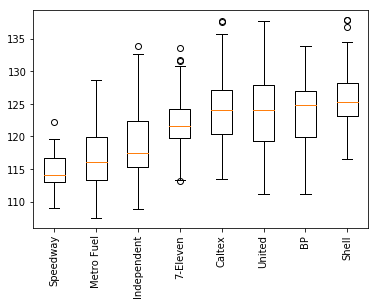

Mean fuel price variation for U91


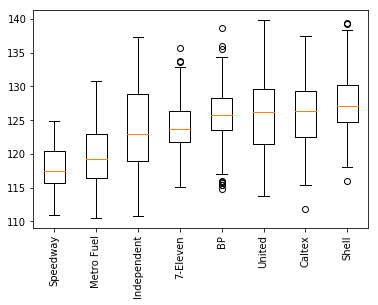

Mean fuel price variation for P95


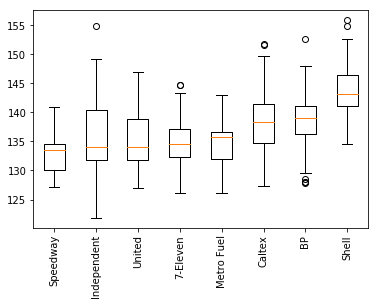

Mean fuel price variation for P98


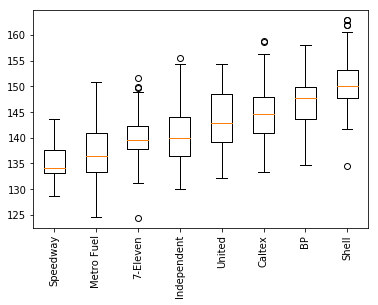

In [17]:
fuel_type = ['E10', 'U91', 'P95', 'P98']
fuel_stats = {}

def weighted_mean(weighted_price, days):
    if days.sum() == 0:
        return weighted_price.sum()/30
    else:
        return weighted_price.sum()/days.sum()

# collect stats for each fuel type at each service station, then store into dictionary 'fuel_stats'
for fuel in fuel_type:
    fuel_subset = fuelcheck[fuelcheck['FuelCode'] == fuel]
    fuel_subset = fuel_subset.sort_values(['Address', 'PriceUpdatedDate'], ascending=True)
    fuel_subset = fuel_subset.reset_index(drop=True)

    fuel_stats_list = []    

    # get stats for each service station and add them to a list. Once the data for each service station is collected,
    # store it in a dataframe
    for address in addresses:
        fuel_station = fuel_subset[fuel_subset['Address'] == address]
        count = int(len(fuel_station['Price'].index))
        if count > 1:
            mean = weighted_mean(fuel_station['WeightedPrice'], fuel_station['Weighting'])
            std_dev = fuel_station['Price'].std()
            brand = fuel_station['Brand'].iloc[0]
            fuel_stats_list.append(dict(zip(['Brand', 'Address', 'Mean','Std Dev','Count'], [brand, address, mean, std_dev, count])))

    fuel_stats[fuel] = pd.DataFrame(fuel_stats_list)
    fuel_stats[fuel] = fuel_stats[fuel].sort_values('Mean', ascending=True)
    fuel_stats[fuel] = fuel_stats[fuel].set_index('Address')

# break down data into different brands and then plot mean fuel price boxplots
for fuel in fuel_type:
    petrol_prices = {}
    sort_dict = {}
    for brand in brands:
        df = fuel_stats[fuel]
        brand_subset = df[df['Brand'] == brand]
        sort_dict[brand] = brand_subset['Mean'].median()
        petrol_prices[brand] = brand_subset['Mean'].tolist()

    plot_values = [petrol_prices[k] for k in sorted(sort_dict, key=sort_dict.get)]
    sorted_brands = [k for k in sorted(sort_dict, key=sort_dict.get)]
    
    plt.boxplot(plot_values)
    plt.xticks(range(1,len(sorted_brands)+1), sorted_brands, rotation=90)
    print('Mean fuel price variation for ' + fuel)
    plt.show()

# Analysis

The weighted mean fuel prices have been plotted in a series of box plots for each fuel grade, and then ordered by median. A quick overview of the four petrol grades indicates that Shell consistently has the highest median weighted mean price while Speedway has the lowest median weighted price.

Furthermore, Speedway also tends to have the narrowest range in weighted mean prices across all fuel types. This means one can expect to pay a similar price for any type of fuel if they drop into any Speedway petrol station. The widest range in prices appears to be United for E10 and U91, Caltex for P95 and Metro for P98. The Independent category is disregarded for now as it is a mix of several fuel brands, generally small players.

There appears to be little variation in the median price at the lower end of the fuel grades (E10 and U91) between the 5 most expensive brands. The weighted mean price range also significantly overlaps each other. This contrasts against P95 and P98 fuel where there is a visible difference not only between the median price of fuel, but also the range of weighted mean prices. This indicates that the various brands compete on lower grades of fuel, and less so with premium grades of fuel. This makes sense as it is often the E10 fuel price that is most prominently displayed on petrol station advertising boards, with higher fuel grades less prominent down the bottom of the sign.

As the premium grades of fuel tend to differ more significantly than the lower grades of fuel, the "mark up" or delta for each brand relative to E10 must also vary. We'll find out by how much below. Prices are being compared to E10 as it is fuel grade that the brands compete on, and advertise most aggressively.

In [33]:
deltas = fuel_stats['E10']
deltas = deltas.loc[:, ['Brand', 'Mean']]

for i, fuel in enumerate(fuel_type):
    if (i > 0) and (i < len(fuel_type)):
        deltas['Delta ' + fuel_type[i] + '-E10'] = fuel_stats[fuel_type[i]]['Mean'] - fuel_stats['E10']['Mean']
        
deltas.head()

,Brand,Mean,Delta U91-E10,Delta P95-E10,Delta P98-E10
Address,,,,,
"281 Homer St, EARLWOOD NSW 2206",Metro Fuel,107.519914,3.462665,NaN,17.120878
"150 Pacific Hwy, TUGGERAH NSW 2259",Metro Fuel,108.563290,2.000000,NaN,21.276072
"101 Blaxcell St, GRANVILLE NSW 2142",Independent,108.878478,2.000000,13.0,NaN
"348 Blaxcell Street, Granville NSW 2142",Speedway,108.940785,2.000000,NaN,20.354939
"53 Sydney Rd, Goulburn NSW 2580",Independent,109.159449,NaN,NaN,NaN


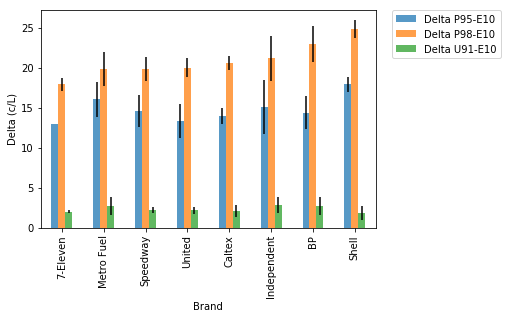

In [34]:
deltas = deltas.set_index(['Brand'])
group_delta_by_brand = deltas.groupby(level=('Brand'))

mean_delta_by_brand = group_delta_by_brand.mean()
mean_delta_by_brand = mean_delta_by_brand.sort_values('Delta P98-E10')

error_by_brand = group_delta_by_brand.std()
error_by_brand = error_by_brand.reindex(mean_delta_by_brand.index)

fig, ax = plt.subplots()

mean_delta_by_brand[mean_delta_by_brand.columns.difference(['Mean'])].plot(kind='bar', alpha=0.75, rot=0, yerr = error_by_brand, ax=ax)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Delta (c/L)')
plt.show()

# Analysis

From the chart above, the error bars (one standard deviation) represent a narrow range relative to the actual delta. Therefore, it can be reasonable to assume that all petrol stations of a particular brand will have a constant price difference between their fuel grades.

7-11 can be seen to have the lowest price difference between E10 and P95, and E10 and P98, with 12.99c/L and 17.94c/L respectively. Shell, as expected, has the largest price difference between E10 and P95, and E10 and P98, with 17.89c/L and 24.77c/L respectively. The price difference between U91 and E10 does not vary significantly between brands.

Again, the Independent service stations have the largest standard deviation likely because this category combines a range of smaller brand service stations e.g. Puma Energy, Matilda, Liberty, Enhance etc. The delta charged between the different brands for the various fuel grades will vary.

The delta for P95 is also not consistent with P98 pricing. For example, while BP has a greater E10-P98 delta compared to Caltex, their E10-P95 delta is about the same as Caltex's. This is even clearer with Metro, which is at the lower end of the spectrum for E10-P98 delta, but has the second highest E10-P95 delta.

# Conclusion

It has been demonstrated that for May Fuelcheck data, Speedway has the lowest overall prices for all fuel grades, and Shell has the highest. Furthermore, while Shell is reasonably competitive for E10, Shell charges the highest mark up for premium fuels, making it the most expensive petrol station to shop at.

# Future Work

The current analysis does not factor in geographical location. Fuel prices could be affected by location (leasing costs, transportation costs, expected customers, wealth of residents etc).

Code requires significant refactoring to make better use of the Pandas library. This is a first attempt to perform an analysis and a learning experience using Python, therefore there are many sub-optimal (or even poor) coding practices applied.